# Yelp Regression Model

In [29]:
from collections.abc import Sequence
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low

### Import Business and Review Data

In [4]:
import pandas as pd
import numpy as np

# Convert Data from JSON to Pandas
reviews = pd.read_json('yelp_academic_dataset_review.json', lines=True, nrows=1000000)

business = pd.read_json('yelp_academic_dataset_business.json', lines=True, nrows=1000000)

# Rename to distinguish star ratings after join
reviews = reviews.rename(columns={'stars': 'review_rating'})
business = business.rename(columns={'stars': 'business_rating'})


In [6]:
# Add Location Column
business['location'] = business['city'] + ", " + business['state']

# Filter businesses out (review_count < 20 and null business_id & review_count)
business =  business[business.review_count > 20]

# Remove all business with no business_id, review_count, and business_rating
business = business.dropna(subset=[
  'business_id', 'review_count', 'business_rating'
])

business.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,business_rating,review_count,is_open,attributes,categories,hours,location
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ...","Tucson, AZ"
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ...","Philadelphia, PA"
12,il_Ro8jwPlHresjw9EGmBg,Denny's,8901 US 31 S,Indianapolis,IN,46227,39.637133,-86.127217,2.5,28,1,"{'RestaurantsReservations': 'False', 'Restaura...","American (Traditional), Restaurants, Diners, B...","{'Monday': '6:0-22:0', 'Tuesday': '6:0-22:0', ...","Indianapolis, IN"
14,0bPLkL0QhhPO5kt1_EXmNQ,Zio's Italian Market,2575 E Bay Dr,Largo,FL,33771,27.916116,-82.760461,4.5,100,0,"{'OutdoorSeating': 'False', 'RestaurantsGoodFo...","Food, Delis, Italian, Bakeries, Restaurants","{'Monday': '10:0-18:0', 'Tuesday': '10:0-20:0'...","Largo, FL"
15,MUTTqe8uqyMdBl186RmNeA,Tuna Bar,205 Race St,Philadelphia,PA,19106,39.953949,-75.143226,4.0,245,1,"{'RestaurantsReservations': 'True', 'Restauran...","Sushi Bars, Restaurants, Japanese","{'Tuesday': '13:30-22:0', 'Wednesday': '13:30-...","Philadelphia, PA"


In [9]:
# Merge the business and reviews together 
all_reviews = pd.merge(reviews,business, on='business_id') 

print(all_reviews.columns)
all_reviews.head()
# all_reviews.head()

Index(['review_id', 'user_id', 'business_id', 'review_rating', 'useful',
       'funny', 'cool', 'text', 'date', 'name', 'address', 'city', 'state',
       'postal_code', 'latitude', 'longitude', 'business_rating',
       'review_count', 'is_open', 'attributes', 'categories', 'hours',
       'location'],
      dtype='object')


,review_id,user_id,business_id,review_rating,useful,funny,cool,text,date,name,...,postal_code,latitude,longitude,business_rating,review_count,is_open,attributes,categories,hours,location
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11,Turning Point of North Wales,...,19454,40.210196,-75.223639,3.0,169,1,"{'NoiseLevel': 'u'average'', 'HasTV': 'False',...","Restaurants, Breakfast & Brunch, Food, Juice B...","{'Monday': '7:30-15:0', 'Tuesday': '7:30-15:0'...","North Wales, PA"
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18,Body Cycle Spinning Studio,...,19119,39.952103,-75.172753,5.0,144,0,"{'BusinessAcceptsCreditCards': 'True', 'GoodFo...","Active Life, Cycling Classes, Trainers, Gyms, ...","{'Monday': '6:30-20:30', 'Tuesday': '6:30-20:3...","Philadelphia, PA"
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30,Kettle Restaurant,...,85713,32.207233,-110.980864,3.5,47,1,"{'RestaurantsReservations': 'True', 'BusinessP...","Restaurants, Breakfast & Brunch",None,"Tucson, AZ"
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03,Zaika,...,19114,40.079848,-75.025080,4.0,181,1,"{'Caters': 'True', 'Ambience': '{'romantic': F...","Halal, Pakistani, Restaurants, Indian","{'Tuesday': '11:0-21:0', 'Wednesday': '11:0-21...","Philadelphia, PA"
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15,Melt,...,70119,29.962102,-90.087958,4.0,32,0,"{'BusinessParking': '{'garage': False, 'street...","Sandwiches, Beer, Wine & Spirits, Bars, Food, ...","{'Monday': '0:0-0:0', 'Friday': '11:0-17:0', '...","New Orleans, LA"


In [64]:
# Combine all the business's reviews into one text
business_reviews = all_reviews.groupby('business_id')['text'].sum()

# # Create a dataframe with the business and its all its cooresponding reviews
df_business_reviews = pd.DataFrame({
  'business_id' : business_reviews.index, 
  'all_reviews' : business_reviews.values,
})

df_business_reviews = pd.merge(df_business_reviews, business[['business_id', 'business_rating']], on='business_id')

In [20]:
df_business_reviews.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,business_rating,review_count,is_open,attributes,categories,hours,location,all_reviews
0,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ...","Tucson, AZ",We are fans of Target. They seem to have a li...
1,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ...","Philadelphia, PA",This is nice little Chinese bakery in the hear...
2,il_Ro8jwPlHresjw9EGmBg,Denny's,8901 US 31 S,Indianapolis,IN,46227,39.637133,-86.127217,2.5,28,1,"{'RestaurantsReservations': 'False', 'Restaura...","American (Traditional), Restaurants, Diners, B...","{'Monday': '6:0-22:0', 'Tuesday': '6:0-22:0', ...","Indianapolis, IN",Went there at 4am and there was only one waitr...
3,0bPLkL0QhhPO5kt1_EXmNQ,Zio's Italian Market,2575 E Bay Dr,Largo,FL,33771,27.916116,-82.760461,4.5,100,0,"{'OutdoorSeating': 'False', 'RestaurantsGoodFo...","Food, Delis, Italian, Bakeries, Restaurants","{'Monday': '10:0-18:0', 'Tuesday': '10:0-20:0'...","Largo, FL",The worst Chicken Parm. Sandwich I've ever eat...
4,MUTTqe8uqyMdBl186RmNeA,Tuna Bar,205 Race St,Philadelphia,PA,19106,39.953949,-75.143226,4.0,245,1,"{'RestaurantsReservations': 'True', 'Restauran...","Sushi Bars, Restaurants, Japanese","{'Tuesday': '13:30-22:0', 'Wednesday': '13:30-...","Philadelphia, PA",Stopped in to check out this new spot around t...


In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

text = df_business_reviews['all_reviews']
text.head()

# Initialize the TF-IDF vectorizer
vectorizer = TfidfVectorizer(stop_words='english',max_features=5000,min_df=1)
# Fit and transform the aggregated reviews into a TF-IDF matrix
tfidf_wm = vectorizer.fit_transform(text)

# Retrieve the feature names (i.e., the vocabulary)
tfidf_tokens = vectorizer.get_feature_names_out()

# Create a DataFrame from the TF-IDF matrix for easier viewing
df_tfidfvect = pd.DataFrame(data=tfidf_wm.toarray(), columns=tfidf_tokens)

(11520, 5000) (11520, 2)


In [22]:
df_tfidfvect.head()

,00,000,00pm,10,100,1000,10am,10pm,11,11am,...,york,young,younger,yuck,yum,yummy,zero,zone,zoo,zucchini
0,0.010745,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.026259,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.001932,0.012100,0.0,0.0,0.0,0.0,0.0,...,0.0,0.002882,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.072024,0.0,0.0,0.000000,0.037985,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [69]:
from sklearn.model_selection import train_test_split

# x = df_tfidfvect
# y = df_business_reviews['business_rating']
# # Split into train/test
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)


# print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

# Combine x and y into a single DataFrame
df_combined = pd.concat([df_tfidfvect, df_business_reviews['business_rating']], axis=1)

# Use the to_xy function to convert the DataFrame to x and y arrays
x, y = to_xy(df_combined, 'business_rating')

# Now split the transformed data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

# Check the shape of the resulting arrays
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(9216, 5000) (9216,) (2304, 5000) (2304,)


In [70]:
# Imports for all the models
%matplotlib inline
from matplotlib.pyplot import figure, show
from sklearn import metrics

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam, SGD

Epoch 1/100
288/288 - 13s - loss: 0.5108 - val_loss: 0.2133 - 13s/epoch - 47ms/step
Epoch 2/100
288/288 - 9s - loss: 0.1780 - val_loss: 0.2063 - 9s/epoch - 31ms/step
Epoch 3/100
288/288 - 8s - loss: 0.1432 - val_loss: 0.2124 - 8s/epoch - 29ms/step
Epoch 4/100
288/288 - 9s - loss: 0.1267 - val_loss: 0.2016 - 9s/epoch - 32ms/step
Epoch 5/100
288/288 - 9s - loss: 0.1185 - val_loss: 0.2318 - 9s/epoch - 33ms/step
Epoch 6/100
288/288 - 9s - loss: 0.1190 - val_loss: 0.2256 - 9s/epoch - 31ms/step
Epoch 6: early stopping
72/72 [==============================] - 1s 6ms/step
Score (RMSE): 0.4490430951118469


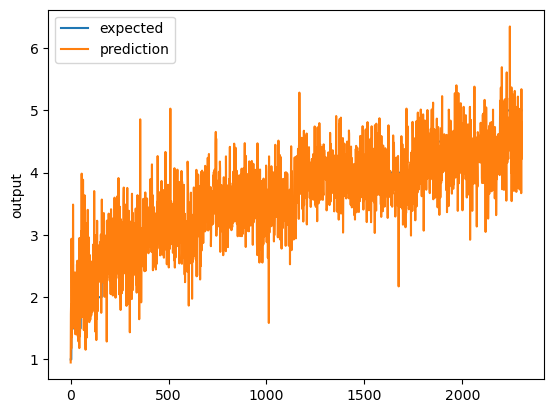

In [71]:
# Model # 1
# NO Location, No Review_count, Only text features # = 1000

parameters = {
  'learning_rate' : 0.001, 
  'batch_size' : 32, 
  'epochs' : 100
}

# Initialize Optimizers
adam = optimizers.Adam(learning_rate=parameters['learning_rate'], beta_1=0.9, beta_2=0.999)
sgd = optimizers.SGD(learning_rate=parameters['learning_rate'], momentum=0.9, nesterov=True)  

# Initialize ModelCheckpoint and EarlyStopping
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=2, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath="dnn/best_weights1.keras", verbose=0, save_best_only=True)

model = Sequential()
model.add(Dense(1000, input_dim=x.shape[1]))
model.add(Dense(512))
model.add(Dense(100))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer=adam)

model.fit(
  x_train,y_train, validation_data=(x_test,y_test), 
  batch_size= parameters['batch_size'], callbacks=[monitor, checkpointer],
  verbose=2,epochs=parameters['epochs']
)

model.load_weights('dnn/best_weights1.keras') # load weights from best model

# Predict and measure RMSE
pred = model.predict(x_test)
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Score (RMSE): {}".format(score))

# Plot the chart
chart_regression(pred.flatten(),y_test)